# Lab2 NMT

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.7 MB/s eta 0:00:00


In [6]:
import os

# dataset
path_do_data = './data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

In [7]:
import math
import random
from functools import partial

import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from train import train_model, evaluate
from data_utils import En2RuDataset, process_data, generate_batch
from train_utils import (init_weights, init_weights_xavier, count_parameters, 
                         calc_bleu, plot_history, calc_inference_speed)

random.seed(0)
torch.manual_seed(0);

In [8]:
en_ru_tensors, en_vocab, ru_vocab = process_data('data.txt')
en_ru_lengths = [(len(en_t), len(ru_t)) for en_t, ru_t in en_ru_tensors]
print('en/ru max tensors length:', *max(en_ru_lengths))

en/ru max tensors length: 99 80


## Baseline LSTM Seq2Seq

In [ ]:
from models.lstm_baseline import Encoder, Decoder, Seq2Seq

In [ ]:
BATCH_SIZE = 128

en2ru_dataset = En2RuDataset(en_ru_tensors)
train_data, val_data, test_data = random_split(en2ru_dataset, lengths=[0.8, 0.15, 0.05])
print(f'train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}')

collate_fn = partial(generate_batch, en_vocab=en_vocab, ru_vocab=ru_vocab, batch_first=False)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train: 40000, val: 7500, test: 2500


In [ ]:
INPUT_DIM = len(en_vocab)  # len(source_vocab)
OUTPUT_DIM = len(ru_vocab)  # len(target_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
NUM_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, NUM_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, NUM_LAYERS, DEC_DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

MODEL_NAME = 'baseline_model'
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15
CLIP = 1

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# when scoring the performance of a language translation model in particular,
# we have to tell the nn.CrossEntropyLoss function to ignore the indices where
# the target is simply padding
criterion = nn.CrossEntropyLoss(ignore_index=ru_vocab['<pad>'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True
)

device: cuda
The model has 17,664,815 trainable parameters


In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7828, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10799, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10799, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
%%time
train_history, val_history = train_model(
    model, device, NUM_EPOCHS,
    train_loader, val_loader, optimizer, criterion,
    scheduler, CLIP, model_name=MODEL_NAME
)

evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.93it/s]


Epoch: 01 | Time: 2m 12s
	Train Loss: 5.661 | Train PPL: 287.450
	 Val. Loss: 5.878 |  Val. PPL: 357.214


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.87it/s]


Epoch: 02 | Time: 2m 10s
	Train Loss: 4.664 | Train PPL: 106.033
	 Val. Loss: 5.734 |  Val. PPL: 309.182


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.77it/s]


Epoch: 03 | Time: 2m 11s
	Train Loss: 4.028 | Train PPL:  56.161
	 Val. Loss: 5.533 |  Val. PPL: 252.994


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.83it/s]


Epoch: 04 | Time: 2m 11s
	Train Loss: 3.713 | Train PPL:  40.957
	 Val. Loss: 5.387 |  Val. PPL: 218.528


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.96it/s]


Epoch: 05 | Time: 2m 11s
	Train Loss: 3.488 | Train PPL:  32.715
	 Val. Loss: 5.274 |  Val. PPL: 195.105


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.92it/s]


Epoch: 06 | Time: 2m 18s
	Train Loss: 3.319 | Train PPL:  27.644
	 Val. Loss: 5.217 |  Val. PPL: 184.408


evaluate: 100%|██████████| 59/59 [00:08<00:00,  7.02it/s]


Epoch: 07 | Time: 2m 13s
	Train Loss: 3.187 | Train PPL:  24.223
	 Val. Loss: 5.182 |  Val. PPL: 178.120


evaluate: 100%|██████████| 59/59 [00:09<00:00,  6.00it/s]


Epoch: 08 | Time: 2m 16s
	Train Loss: 3.074 | Train PPL:  21.637
	 Val. Loss: 5.070 |  Val. PPL: 159.198


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.78it/s]


Epoch: 09 | Time: 2m 13s
	Train Loss: 2.995 | Train PPL:  19.977
	 Val. Loss: 5.136 |  Val. PPL: 170.005


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.91it/s]


Epoch: 10 | Time: 2m 9s
	Train Loss: 2.909 | Train PPL:  18.338
	 Val. Loss: 5.039 |  Val. PPL: 154.336


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Epoch: 11 | Time: 2m 12s
	Train Loss: 2.802 | Train PPL:  16.483
	 Val. Loss: 5.080 |  Val. PPL: 160.788


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.85it/s]


Epoch: 12 | Time: 2m 12s
	Train Loss: 2.749 | Train PPL:  15.627
	 Val. Loss: 5.072 |  Val. PPL: 159.484


evaluate: 100%|██████████| 59/59 [00:08<00:00,  7.02it/s]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 13 | Time: 2m 11s
	Train Loss: 2.665 | Train PPL:  14.368
	 Val. Loss: 5.083 |  Val. PPL: 161.212


evaluate: 100%|██████████| 59/59 [00:10<00:00,  5.85it/s]


Epoch: 14 | Time: 2m 21s
	Train Loss: 2.538 | Train PPL:  12.660
	 Val. Loss: 4.986 |  Val. PPL: 146.381


evaluate: 100%|██████████| 59/59 [00:08<00:00,  6.82it/s]

Epoch: 15 | Time: 2m 15s
	Train Loss: 2.524 | Train PPL:  12.483
	 Val. Loss: 5.030 |  Val. PPL: 152.867
CPU times: user 30min 35s, sys: 1min 20s, total: 31min 56s
Wall time: 33min 39s


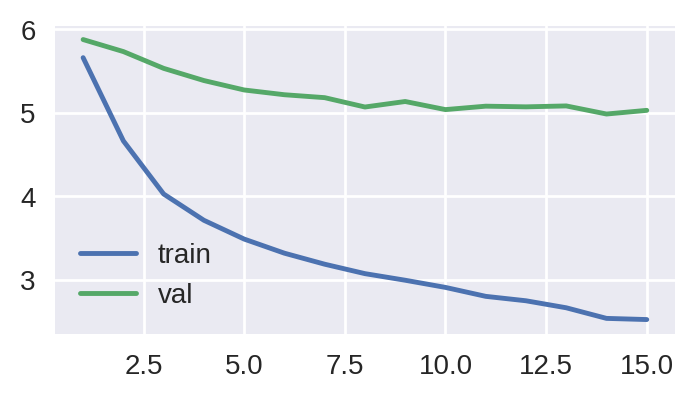

In [ ]:
plot_history(train_history, val_history)

At times, the validation loss is greater than the training loss. This may indicate that the model is underfitting. Underfitting occurs when the model is unable to accurately model the training data, and hence generates large errors.

Furthermore, the results in this scenario indicate that further training is needed to reduce the loss incurred during training. Alternatively, we can also increase the training data either by obtaining more samples or augmenting the data.

In [ ]:
# load best model
with open(f'{MODEL_NAME}.pt', 'rb') as fp:
    checkpoint = torch.load(fp, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

test_loss = evaluate(model, device, test_loader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} \n')

calc_bleu(model, device, test_loader, en_vocab, ru_vocab, num_examples=5)

evaluate: 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]



Test Loss: 5.007 | Test PPL: 149.514 



bleu: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


bleu: 17.919

input: the features rooms and apartments with unique historic interiors and free wi - fi .
target: в номерах и апартаментах отеля с уникальными историческими предоставляется бесплатный wi - fi .
generated: в и . предоставляется бесплатный wi - fi . 

input: the wellness centre features a gym , a sauna and a turkish bath .
target: в оздоровительном центре гости могут посетить тренажерный зал , сауну и турецкую баню .
generated: в спа - центре отеля можно посетить сауну и паровую баню . 

input: you will find a variety of restaurants and shops in the vicinity .
target: рядом с комплексом работает множество ресторанов и магазинов .
generated: в непосредственной близости от отеля работают различные рестораны и рестораны . 

input: jolly amusement park is 3 miles away .
target: расстояние от отеля до парка аттракционов составляет 4 , 8 км .
generated: расстояние до парка - - составляет 3 , 5 км . 

input: you can play table tennis at the guest house .
target: в гостевом доме м

In [ ]:
# benchmark
BATCH_SIZE = 32
speed_test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f'batch size: {BATCH_SIZE}\nnum batches: {len(speed_test_loader)}')

inference_times = calc_inference_speed(model, device, speed_test_loader)

mean_inference_time = sum(inference_times) / len(inference_times)
# number of examples network can process in one second
inference_speed = len(speed_test_loader) * BATCH_SIZE / sum(inference_times)
print(f'\nmean inference time: {mean_inference_time:.2f} s\ninference speed: {inference_speed:.2f} samples/s')

batch size: 32
num batches: 79


speed test: 100%|██████████| 79/79 [00:05<00:00, 13.86it/s]


mean inference time: 0.07 s
inference speed: 472.22 samples/s


## GRU + Attention Seq2Seq

In [ ]:
from models.gru_attention import Encoder, Attention, Decoder, Seq2Seq

In [ ]:
BATCH_SIZE = 128

en2ru_dataset = En2RuDataset(en_ru_tensors)
train_data, val_data, test_data = random_split(en2ru_dataset, lengths=[0.8, 0.15, 0.05])
print(f'train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}')

collate_fn = partial(generate_batch, en_vocab=en_vocab, ru_vocab=ru_vocab, batch_first=False)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train: 40000, val: 7500, test: 2500


In [ ]:
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(ru_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attention = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attention)
model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

MODEL_NAME = 'attention_model'
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
CLIP = 1

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=ru_vocab['<pad>'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True
)

device: cuda
The model has 29,875,311 trainable parameters


In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7828, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=64, bias=True)
    )
    (embedding): Embedding(10799, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=10799, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
%%time
train_history, val_history = train_model(
    model, device, NUM_EPOCHS,
    train_loader, val_loader, optimizer, criterion,
    scheduler, CLIP, model_name=MODEL_NAME
)

evaluate: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s]


Epoch: 01 | Time: 4m 18s
	Train Loss: 4.570 | Train PPL:  96.540
	 Val. Loss: 4.832 |  Val. PPL: 125.462


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch: 02 | Time: 4m 16s
	Train Loss: 3.230 | Train PPL:  25.283
	 Val. Loss: 4.719 |  Val. PPL: 112.077


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch: 03 | Time: 4m 17s
	Train Loss: 2.766 | Train PPL:  15.898
	 Val. Loss: 4.603 |  Val. PPL:  99.790


evaluate: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Epoch: 04 | Time: 4m 19s
	Train Loss: 2.449 | Train PPL:  11.577
	 Val. Loss: 4.661 |  Val. PPL: 105.721


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch: 05 | Time: 4m 17s
	Train Loss: 2.232 | Train PPL:   9.319
	 Val. Loss: 4.652 |  Val. PPL: 104.813


evaluate: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Epoch: 06 | Time: 4m 18s
	Train Loss: 2.027 | Train PPL:   7.593
	 Val. Loss: 4.586 |  Val. PPL:  98.100


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch: 07 | Time: 4m 16s
	Train Loss: 1.861 | Train PPL:   6.427
	 Val. Loss: 4.688 |  Val. PPL: 108.601


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch: 08 | Time: 4m 16s
	Train Loss: 1.750 | Train PPL:   5.755
	 Val. Loss: 4.782 |  Val. PPL: 119.335


evaluate: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s]


Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 09 | Time: 4m 19s
	Train Loss: 1.666 | Train PPL:   5.292
	 Val. Loss: 4.786 |  Val. PPL: 119.808


evaluate: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]

Epoch: 10 | Time: 4m 19s
	Train Loss: 1.430 | Train PPL:   4.180
	 Val. Loss: 4.949 |  Val. PPL: 141.051
CPU times: user 29min 16s, sys: 13min 27s, total: 42min 44s
Wall time: 43min 16s


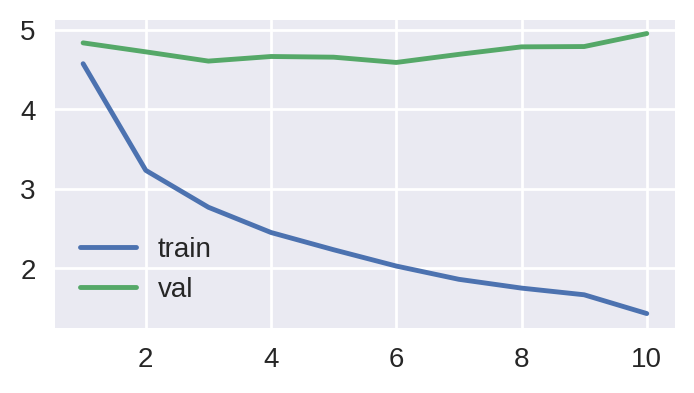

In [ ]:
plot_history(train_history, val_history)

Overfitting occurs after 6 epochs.

In [ ]:
# load best model
with open(f'{MODEL_NAME}.pt', 'rb') as fp:
    checkpoint = torch.load(fp, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

test_loss = evaluate(model, device, test_loader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} \n')

calc_bleu(model, device, test_loader, en_vocab, ru_vocab, num_examples=5)

evaluate: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]



Test Loss: 4.579 | Test PPL:  97.393 



bleu: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


bleu: 29.437

input: rome ciampino airport is 17 km away .
target: расстояние до аэропорта рим - чампино составляет 17 км .
generated: расстояние до аэропорта фьюмичино составляет 17 км . 

input: free parking is available .
target: для гостей обустроена бесплатная парковка .
generated: гостям предоставляется бесплатная парковка . 

input: the accommodation has a flat - screen tv . some units feature a terrace and / or balcony .
target: во всех домах для отпуска установлен телевизор с плоским экраном , а в некоторых из них обустроена терраса и / или балкон .
generated: в числе удобств телевизор с плоским экраном и а в некоторых — терраса и / или балкон . 

input: the four bedroom apartment has two bedrooms with double beds and two bedrooms with two single beds each .
target: в распоряжении гостей 4 спальни , в 2 из которых установлены двуспальные кровати , а в других — по 2 односпальные кровати .
generated: в апартаментах с 4 спальнями , 2 спальни с 2 односпальными кроватями и 2 односп

In [ ]:
# benchmark
BATCH_SIZE = 32
speed_test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f'batch size: {BATCH_SIZE}\nnum batches: {len(speed_test_loader)}')

inference_times = calc_inference_speed(model, device, speed_test_loader)

mean_inference_time = sum(inference_times) / len(inference_times)
# number of examples network can process in one second
inference_speed = len(speed_test_loader) * BATCH_SIZE / sum(inference_times)
print(f'\nmean inference time: {mean_inference_time:.2f} s\ninference speed: {inference_speed:.2f} samples/s')

batch size: 32
num batches: 79


speed test: 100%|██████████| 79/79 [00:05<00:00, 15.21it/s]


mean inference time: 0.06 s
inference speed: 520.18 samples/s


- slow inference
- good translation quality

## Transformer + Positional Embeddings Seq2Seq

In [ ]:
from models.transformer_pos_emb import Encoder, Decoder, Seq2Seq

In [ ]:
BATCH_SIZE = 128

en2ru_dataset = En2RuDataset(en_ru_tensors)
train_data, val_data, test_data = random_split(en2ru_dataset, lengths=[0.8, 0.15, 0.05])
print(f'train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}')

collate_fn = partial(generate_batch, en_vocab=en_vocab, ru_vocab=ru_vocab, batch_first=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train: 40000, val: 7500, test: 2500


In [ ]:
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(ru_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
encoder = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS,
                  ENC_PF_DIM, ENC_DROPOUT, device, max_length=200)  # max_length, max tensor length x2
decoder = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS,
                  DEC_PF_DIM, DEC_DROPOUT, device, max_length=200)
model = Seq2Seq(encoder, decoder, src_pad_idx=en_vocab['<pad>'], trg_pad_idx=ru_vocab['<pad>'],
                device=device).to(device)
model.apply(init_weights_xavier)
print(f'The model has {count_parameters(model):,} trainable parameters')

MODEL_NAME = 'transformer_model'
LEARNING_RATE = 5e-4
NUM_EPOCHS = 15
CLIP = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=ru_vocab['<pad>'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True)

device: cuda
The model has 11,599,919 trainable parameters


In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7828, 256)
    (pos_embedding): Embedding(200, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )

In [ ]:
%%time
train_history, val_history = train_model(
    model, device, NUM_EPOCHS,
    train_loader, val_loader, optimizer, criterion,
    scheduler, CLIP, model_name=MODEL_NAME,
    transformer=True
)

evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.68it/s]


Epoch: 01 | Time: 0m 40s
	Train Loss: 3.960 | Train PPL:  52.468
	 Val. Loss: 2.661 |  Val. PPL:  14.308


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.71it/s]


Epoch: 02 | Time: 0m 39s
	Train Loss: 2.396 | Train PPL:  10.984
	 Val. Loss: 2.196 |  Val. PPL:   8.986


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.44it/s]


Epoch: 03 | Time: 0m 39s
	Train Loss: 1.957 | Train PPL:   7.075
	 Val. Loss: 1.935 |  Val. PPL:   6.924


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.06it/s]


Epoch: 04 | Time: 0m 39s
	Train Loss: 1.660 | Train PPL:   5.261
	 Val. Loss: 1.793 |  Val. PPL:   6.008


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.64it/s]


Epoch: 05 | Time: 0m 39s
	Train Loss: 1.444 | Train PPL:   4.236
	 Val. Loss: 1.691 |  Val. PPL:   5.426


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.07it/s]


Epoch: 06 | Time: 0m 39s
	Train Loss: 1.270 | Train PPL:   3.561
	 Val. Loss: 1.644 |  Val. PPL:   5.175


evaluate: 100%|██████████| 59/59 [00:02<00:00, 22.93it/s]


Epoch: 07 | Time: 0m 39s
	Train Loss: 1.128 | Train PPL:   3.090
	 Val. Loss: 1.618 |  Val. PPL:   5.041


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.23it/s]


Epoch: 08 | Time: 0m 39s
	Train Loss: 1.012 | Train PPL:   2.752
	 Val. Loss: 1.609 |  Val. PPL:   5.000


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.70it/s]


Epoch: 09 | Time: 0m 39s
	Train Loss: 0.916 | Train PPL:   2.499
	 Val. Loss: 1.622 |  Val. PPL:   5.062


evaluate: 100%|██████████| 59/59 [00:02<00:00, 23.91it/s]


Epoch: 10 | Time: 0m 39s
	Train Loss: 0.837 | Train PPL:   2.309
	 Val. Loss: 1.637 |  Val. PPL:   5.139


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.14it/s]


Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 11 | Time: 0m 39s
	Train Loss: 0.770 | Train PPL:   2.160
	 Val. Loss: 1.674 |  Val. PPL:   5.331


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.29it/s]


Epoch: 12 | Time: 0m 39s
	Train Loss: 0.643 | Train PPL:   1.902
	 Val. Loss: 1.666 |  Val. PPL:   5.292


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.20it/s]


Epoch: 13 | Time: 0m 39s
	Train Loss: 0.582 | Train PPL:   1.790
	 Val. Loss: 1.695 |  Val. PPL:   5.447


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.02it/s]


Epoch 00014: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 14 | Time: 0m 39s
	Train Loss: 0.547 | Train PPL:   1.728
	 Val. Loss: 1.730 |  Val. PPL:   5.642


evaluate: 100%|██████████| 59/59 [00:02<00:00, 24.26it/s]

Epoch: 15 | Time: 0m 39s
	Train Loss: 0.484 | Train PPL:   1.623
	 Val. Loss: 1.743 |  Val. PPL:   5.717
CPU times: user 9min 36s, sys: 3.98 s, total: 9min 40s
Wall time: 9min 52s


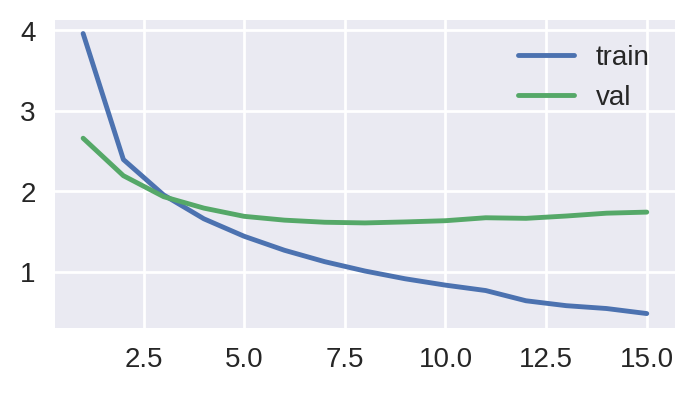

In [ ]:
plot_history(train_history, val_history)

Overfitting occurs after 8 epochs.

In [ ]:
# load best model
with open(f'{MODEL_NAME}.pt', 'rb') as fp:
    checkpoint = torch.load(fp, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

test_loss = evaluate(model, device, test_loader, criterion, transformer=True)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} \n')

calc_bleu(model, device, test_loader, en_vocab, ru_vocab, num_examples=5, transformer=True)

evaluate: 100%|██████████| 20/20 [00:00<00:00, 22.19it/s]



Test Loss: 1.599 | Test PPL:   4.949 



bleu: 100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


bleu: 29.403

input: sample various kinds of alcoholic and non - alcoholic beverages in one of our lively theme bars and simply the and relaxing ambience of this magnificent place .
target: вы можете попробовать всевозможные алкогольные и безалкогольные напитки в одном из оживленных баров , расположенных на территории отеля , или просто расслабиться , и атмосферу этого курорта .
generated: в оформлении отеля использованы различные сорта вин и . 

input: this family - run , 3 - star superior hotel in offers comfortably furnished rooms , a traditional restaurant and free parking .
target: этот семейный 3 - звездочный улучшенный отель расположен в городе . к услугам гостей комфортабельные номера , традиционный ресторан и бесплатная парковка .
generated: этот семейный отель расположен в городе . к услугам гостей традиционный ресторан , бесплатная парковка и традиционный ресторан . 

input: the nearest airport is pulkovo airport , 31 km from apartments on 16 .
target: расстояние до междунар

In [ ]:
# benchmark
BATCH_SIZE = 32
speed_test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f'batch size: {BATCH_SIZE}\nnum batches: {len(speed_test_loader)}')

inference_times = calc_inference_speed(model, device, speed_test_loader, transformer=True)

mean_inference_time = sum(inference_times) / len(inference_times)
# number of examples network can process in one second
inference_speed = len(speed_test_loader) * BATCH_SIZE / sum(inference_times)
print(f'\nmean inference time: {mean_inference_time:.2f} s\ninference speed: {inference_speed:.2f} samples/s')

batch size: 32
num batches: 79


speed test: 100%|██████████| 79/79 [00:00<00:00, 82.93it/s]


mean inference time: 0.01 s
inference speed: 3190.70 samples/s


**Good model**

- fastest inference 🏆
- good translation quality

## BERT Encoder + Transformer Decoder Seq2Seq



In [9]:
from transformers import AutoModel

from models.transformer_pos_emb import EncoderBERT, Decoder, Seq2Seq
from data_utils import process_data_bert, generate_batch_bert, en_bert_tokenizer

In [11]:
BATCH_SIZE = 128

en_ru_tensors, ru_vocab = process_data_bert('data.txt')
en_ru_lengths = [(len(en_t), len(ru_t)) for en_t, ru_t in en_ru_tensors]
print('en/ru max tensors length:', *max(en_ru_lengths))

en2ru_dataset = En2RuDataset(en_ru_tensors)
train_data, val_data, test_data = random_split(en2ru_dataset, lengths=[0.8, 0.15, 0.05])
print(f'train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}')

collate_fn = partial(generate_batch_bert, ru_vocab=ru_vocab, batch_first=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

en/ru max tensors length: 119 80
train: 40000, val: 7500, test: 2500


In [22]:
# https://huggingface.co/docs/transformers/model_doc/distilbert
bert_model = AutoModel.from_pretrained('distilbert-base-cased')
print(bert_model)
print(f'The model has {count_parameters(bert_model):,} trainable parameters')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [35]:
# freeze DistilBERT layers
for param in bert_model.parameters():
    param.requires_grad = False

print(f'The model has {count_parameters(bert_model):,} trainable parameters')

The model has 0 trainable parameters


In [ ]:
# INPUT_DIM = en_bert_tokenizer.vocab_size
OUTPUT_DIM = len(ru_vocab)
HID_DIM = bert_model.config.dim  # 768
# decrease number of encoder layers and heads
# DistilBERT should do its job
ENC_LAYERS = 1
ENC_HEADS = 1
DEC_LAYERS = 2
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
encoder = EncoderBERT(HID_DIM, ENC_LAYERS, ENC_HEADS,
                      ENC_PF_DIM, ENC_DROPOUT, device, emb_bert=bert_model)
decoder = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS,
                  DEC_PF_DIM, DEC_DROPOUT, device, max_length=200)
model = Seq2Seq(encoder, decoder, src_pad_idx=en_bert_tokenizer.pad_token_id, 
                trg_pad_idx=ru_vocab['<pad>'], device=device).to(device)
model.encoder.layers.apply(init_weights_xavier)
model.decoder.apply(init_weights_xavier)
print(f'The model has {count_parameters(model):,} trainable parameters')

MODEL_NAME = 'bert_transformer_model'
LEARNING_RATE = 5e-4
NUM_EPOCHS = 10
CLIP = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=ru_vocab['<pad>'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True)

device: cuda
The model has 30,938,927 trainable parameters


In [ ]:
model

Seq2Seq(
  (encoder): EncoderBERT(
    (embedding): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (drop

In [ ]:
%%time
train_history, val_history = train_model(
    model, device, NUM_EPOCHS,
    train_loader, val_loader, optimizer, criterion,
    scheduler, CLIP, model_name=MODEL_NAME,
    transformer=True
)

evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.68it/s]


Epoch: 01 | Time: 2m 33s
	Train Loss: 2.823 | Train PPL:  16.835
	 Val. Loss: 2.166 |  Val. PPL:   8.727


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.67it/s]


Epoch: 02 | Time: 2m 33s
	Train Loss: 1.902 | Train PPL:   6.698
	 Val. Loss: 1.808 |  Val. PPL:   6.096


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.68it/s]


Epoch: 03 | Time: 2m 33s
	Train Loss: 1.522 | Train PPL:   4.583
	 Val. Loss: 1.629 |  Val. PPL:   5.097


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.67it/s]


Epoch: 04 | Time: 2m 33s
	Train Loss: 1.268 | Train PPL:   3.555
	 Val. Loss: 1.554 |  Val. PPL:   4.733


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.68it/s]


Epoch: 05 | Time: 2m 32s
	Train Loss: 1.085 | Train PPL:   2.961
	 Val. Loss: 1.526 |  Val. PPL:   4.599


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.68it/s]


Epoch: 06 | Time: 2m 32s
	Train Loss: 0.957 | Train PPL:   2.604
	 Val. Loss: 1.533 |  Val. PPL:   4.634


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.60it/s]


Epoch: 07 | Time: 2m 34s
	Train Loss: 0.858 | Train PPL:   2.359
	 Val. Loss: 1.548 |  Val. PPL:   4.702


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.68it/s]


Epoch 00008: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 08 | Time: 2m 33s
	Train Loss: 0.785 | Train PPL:   2.191
	 Val. Loss: 1.577 |  Val. PPL:   4.842


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.67it/s]


Epoch: 09 | Time: 2m 32s
	Train Loss: 0.622 | Train PPL:   1.863
	 Val. Loss: 1.550 |  Val. PPL:   4.712


evaluate: 100%|██████████| 59/59 [00:16<00:00,  3.67it/s]

Epoch: 10 | Time: 2m 33s
	Train Loss: 0.546 | Train PPL:   1.727
	 Val. Loss: 1.591 |  Val. PPL:   4.910
CPU times: user 24min 56s, sys: 7.81 s, total: 25min 4s
Wall time: 25min 57s


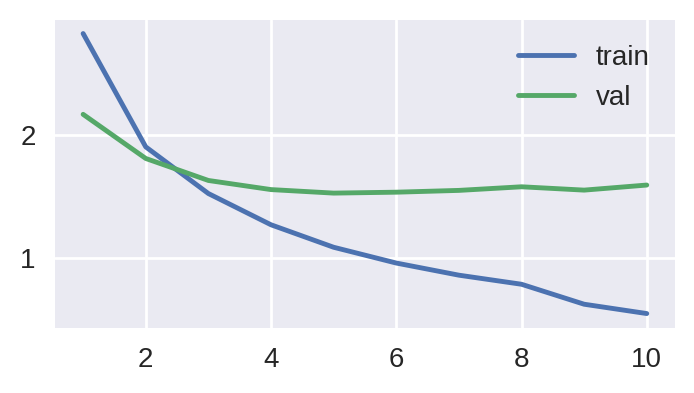

In [ ]:
plot_history(train_history, val_history)

Overfitting occurs after 5 epochs.

In [ ]:
# load best model
with open(f'{MODEL_NAME}.pt', 'rb') as fp:
    checkpoint = torch.load(fp, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

test_loss = evaluate(model, device, test_loader, criterion, transformer=True)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} \n')

calc_bleu(model, device, test_loader, src_vocab=None, trg_vocab=ru_vocab, 
          num_examples=5, transformer=True, src_bert_tokenizer=en_bert_tokenizer)

evaluate: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]



Test Loss: 1.510 | Test PPL:   4.528 



bleu: 100%|██████████| 20/20 [03:56<00:00, 11.82s/it]


bleu: 31.102

input: the nearest airport is ufa international airport, 21 km from apartment park yakutova.
target: расстояние до международного аэропорта от апартаментов « парк » составляет 21 км .
generated: расстояние до международного аэропорта « » составляет 21 км . 

input: sant carles de la ràpita is 30 km from refugi caro uec, while l'ametlla de mar is 40 km from the property.
target: в 30 км от хостела находится городок сан - карлос - де - ла - рапита , а в 40 км — курорт л ’ амеллья - де - мар .
generated: комплекс апартаментов cala de la ville находится в 30 км от города и в 40 км от города кунео . 

input: it offers varied breakfast every morning and specialises in traditional polish cuisine.
target: он специализируется на блюдах традиционной польской кухни , а также тут гостям каждый день подают разнообразный завтрак .
generated: каждое утро для гостей сервируют разнообразный завтрак , а также фирменные блюда традиционной польской кухни . 

input: towels and bed linen are p

In [ ]:
# benchmark
BATCH_SIZE = 32
speed_test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f'batch size: {BATCH_SIZE}\nnum batches: {len(speed_test_loader)}')

inference_times = calc_inference_speed(model, device, speed_test_loader, transformer=True)

mean_inference_time = sum(inference_times) / len(inference_times)
# number of examples network can process in one second
inference_speed = len(speed_test_loader) * BATCH_SIZE / sum(inference_times)
print(f'\nmean inference time: {mean_inference_time:.2f} s\ninference speed: {inference_speed:.2f} samples/s')

batch size: 32
num batches: 79


speed test: 100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


mean inference time: 0.06 s
inference speed: 503.63 samples/s


**Good model**

- slower inference
- best translation quality 🏆